# Moving and adapting

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh
from dune.fem.view import adaptiveLeafGridView as adaptive

file = "grids/vertical.msh"

dim = 2
gridView = adaptive( mmesh((reader.gmsh, file), dim) )

hgrid = gridView.hierarchicalGrid
igridView = hgrid.interfaceGrid

In [2]:
from ufl import *
from dune.ufl import Constant

t = 0
tEnd = 0.2
dt = tEnd / 4.

def speed():
    return as_vector([1.0, 0.0])

def movement(x):
    return as_vector([1.0, 0.0])

def f(u):
    return speed() * u

def u0(x):
    return conditional(x[0] < 0.5, x[0], 0.0)

def uexact(x, t):
    return u0( x - t * speed() )

In [3]:
from dune.fem.space import finiteVolume

space = finiteVolume(gridView)
u = TrialFunction(space)
v = TestFunction(space)

x = SpatialCoordinate(space)
n = FacetNormal(space)

uh = space.interpolate(u0(x), name="uh")
uh_old = uh.copy()

In [4]:
import numpy as np
from dune.geometry import vertex
from dune.mmesh import edgeMovement

def getShifts():
    mapper = igridView.mapper({vertex: 1})
    shifts = np.zeros((mapper.size, dim))
    for v in igridView.vertices:
        shifts[ mapper.index(v) ] = as_vector(movement( v.geometry.center ))
    return shifts

em = edgeMovement(gridView, getShifts())
time = Constant(t, name="time")

def g(u, n):
    sgn = inner(speed(), n('+'))
    return inner( conditional( sgn > 0, f( u('+') ), f( u('-') ) ), n('+') )

def gBnd(u, n):
    sgn = inner(speed(), n)
    return inner( conditional( sgn > 0, f(u), f(uexact(x, time)) ), n )

def h(u, n):
    sgn = inner(em('+'), n('+'))
    return conditional( sgn > 0, sgn * u('+'), sgn * u('-') )

In [5]:
from dune.fem.scheme import galerkin

tau = Constant(dt, name="tau")
detPsi = abs(det(nabla_grad(x + tau * em)))

a = (u * detPsi - uh_old) * v * dx
a += tau * (g(u, n) - h(u, n)) * jump(v) * dS
a += tau * gBnd(u, n) * v * ds

scheme = galerkin([a == 0], solver=("suitesparse","umfpack"))

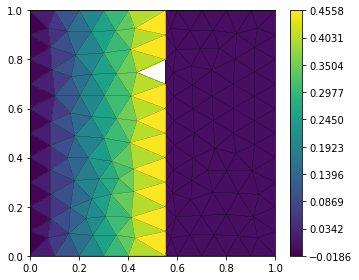

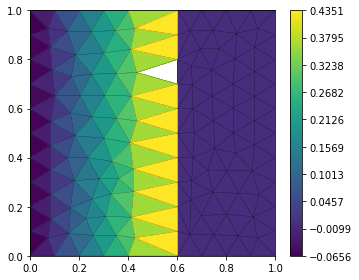

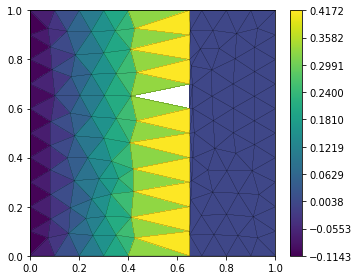

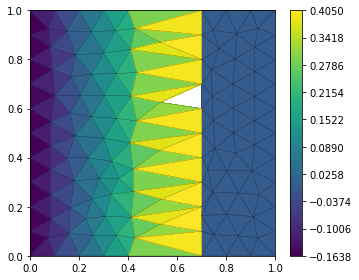

In [6]:
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
from dune.fem.plotting import plotPointData as plot

while t < tEnd:
    hgrid.markElements()
    hgrid.ensureInterfaceMovement(getShifts()*dt)
    adapt([uh])

    hgrid.moveInterface(getShifts()*dt)

    em.assign(edgeMovement(gridView, getShifts()))
    t += dt
    time.assign(t)

    uh_old.assign(uh)
    scheme.solve(target=uh)
    
    plot(uh)